In [2]:
import pandas as pd  
import numpy as np
from numpy.random import dirichlet, random
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco

In [ ]:
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
with pd.HDFStore('../../00_data/assets.h5') as store:
    
    df = store['securities'].drop(['Treasury Index', 'S&P 500'], axis=1).fillna(method='ffill')
    df = df.join(store['sp500'].Close.to_frame('SP500'))
    returns = df.pct_change().dropna()
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2001-08-31 to 2018-06-19
Freq: B
Data columns (total 7 columns):
10-Year Treasury CMR                   4383 non-null float64
US High Yield TRI                      4383 non-null float64
US Corp Master TRI                     4383 non-null float64
Gold (London, USD)                     4383 non-null float64
Emerging Markets Corporate Plus TRI    4383 non-null float64
BCOM                                   4383 non-null float64
SP500                                  4383 non-null float64
dtypes: float64(7)
memory usage: 273.9 KB


In [18]:
def get_quandl_wiki(stocks='all', start=2010, end=2017, na_thres=.8):
    with pd.HDFStore('assets.h5') as store:
        df = store.get('wiki').adj_close.unstack().loc[str(start):str(end)]
        if isinstance(stocks, list):
            df = df.filter(stocks)
        return df.dropna(thresh=int(len(df) * na_thres), axis=1)

In [19]:
with pd.HDFStore('assets.h5') as store:
    sp500 = store['sp500_constituents'].ticker.sample(n=50).tolist()
    prices = get_quandl_wiki(stocks=sp500, start=2010, end=2017)
    returns = prices.pct_change().dropna()

In [20]:
mean_returns = returns.mean()
n_assets = len(mean_returns)
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [21]:
n_assets

46

In [22]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(
        cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [23]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        if i % 5000 == 0:
            print(i)
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [24]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

0
5000
10000
15000
20000
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.2


ticker         A   AAL   AAN  AAON   AAP  AAPL   AAT  AAWW  ABAX   ABC  ...   \
allocation  0.06  0.05  0.01  0.05  0.02  0.06  0.04  0.05  0.02  0.01  ...    

ticker       YUM  ZAGG   ZBH  ZBRA  ZEUS  ZGNX  ZION  ZIOP  ZIXI  ZUMZ  
allocation  0.05  0.04  0.03   0.0  0.05  0.02   0.0  0.05   0.0  0.05  

[1 rows x 2379 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.18
Annualised Volatility: 0.18


ticker         A   AAL   AAN  AAON   AAP  AAPL   AAT  AAWW  ABAX   ABC  ...   \
allocation  0.06  0.06  0.03  0.07  0.07  0.04  0.08   0.0  0.06  0.07  ...    

ticker       YUM  ZAGG   ZBH  ZBRA  ZEUS  ZGNX  ZION  ZIOP  ZIXI  ZUMZ  
allocation  0.05  0.04  0.03  0.01  0.03  0.08  0.04  0.

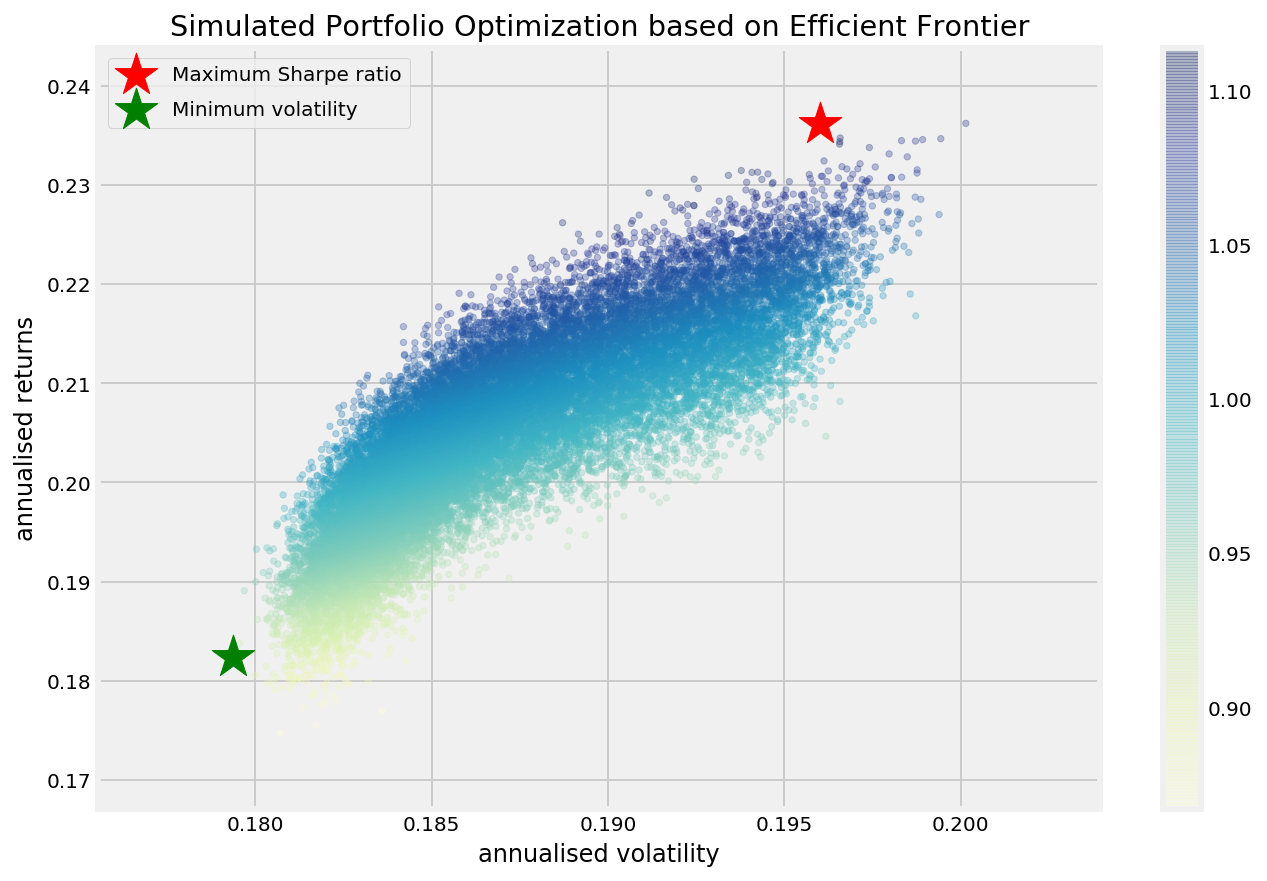

In [46]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [25]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [26]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [27]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [28]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

0
5000
10000
15000
20000
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.13


ticker      CMG  SLG  TRV   UNP    LB  PHM  CNP  PLD   CCI   CBOE ...   UNM  \
allocation  0.0  0.0  0.0  0.88  1.29  0.0  0.0  0.0  4.73  15.78 ...   0.0   

ticker      MAS  SIVB   KMB  EMN   ATVI   HSY   CL  UHS  DIS  
allocation  0.0   0.0  2.62  0.0  11.96  8.04  0.0  0.0  0.0  

[1 rows x 46 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.11


ticker       CMG  SLG   TRV  UNP   LB  PHM  CNP  PLD   CCI  CBOE ...   UNM  \
allocation  1.45  0.0  1.11  0.0  0.0  0.0  0.0  0.0  5.77  7.41 ...   0.0   

ticker      MAS  SIVB    KMB  EMN  ATVI   HSY    CL  UHS  DIS  
allocation  0.0   0.0  16.28  0.0   0.0  10.2  2.18  0.0  0.0  

[1 rows x 46 columns]


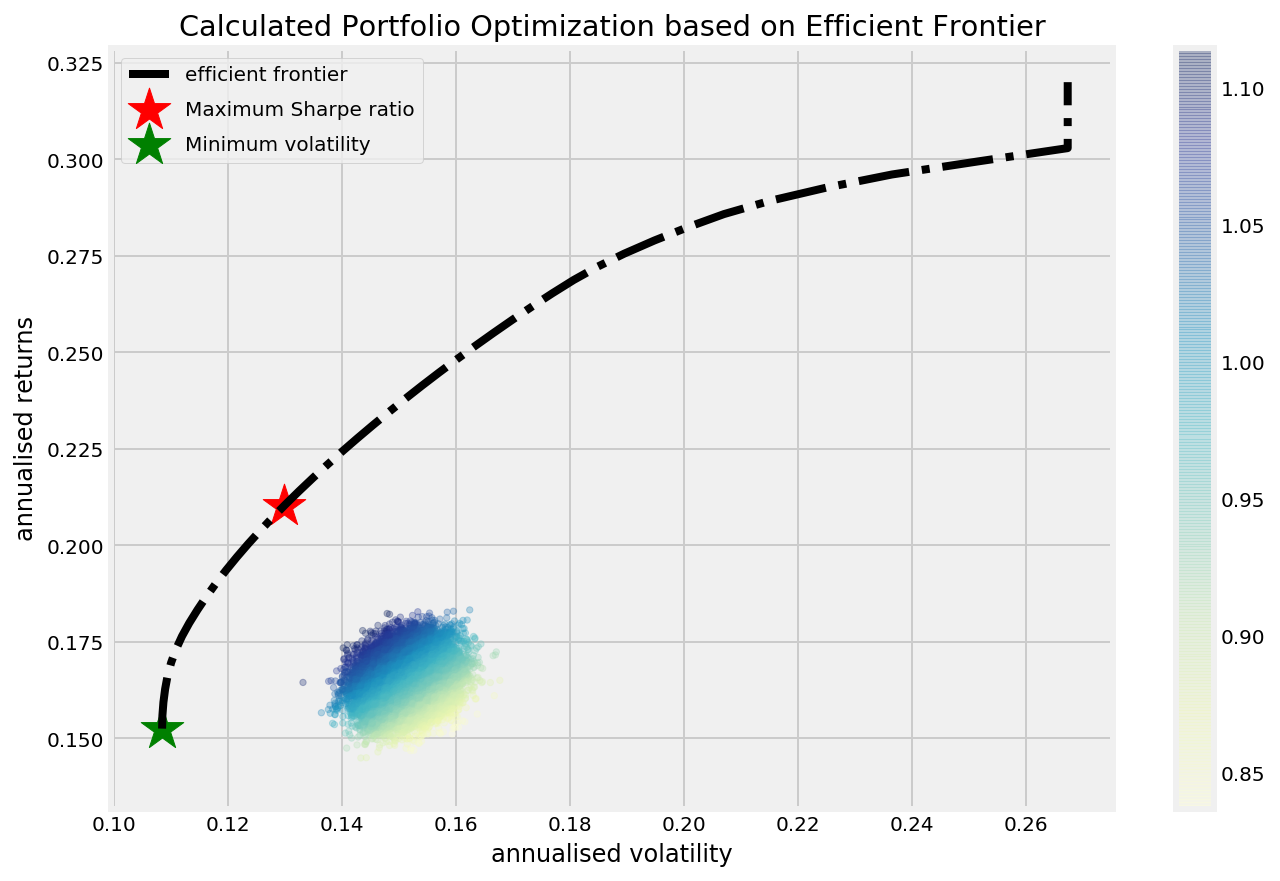

In [29]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)